In [2]:
GPU_ID = 0 # which GPU to use ? 
import os
os.environ["CUDA_VISIBLE_DEVICES"]=f"{GPU_ID}"
device = f'cuda:{GPU_ID}'
import sys
from re import I
sys.path.append('../')
from vq_gan_3d.model.vqgan import VQGAN
import torch
from ddpm import Unet3D, GaussianDiffusion, Trainer
from train.get_dataset import get_dataset
from hydra import initialize, compose
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
datasets_folder = ""
dataset_name = "sci-paris"
DDPM_CHECKPOINT = f'ddpm_model.pt'
VQGAN_CHECKPOINT = "vqgan.ckpt"

USE_DATASET='BIDS'

			
if USE_DATASET=='BIDS':
	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
				"dataset=bids",
				f"dataset.root_dir={datasets_folder}/{dataset_name}",
				"dataset.mandatory_derivates=['contrast-agnostic', lesion-manual]",
				f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
				"model.diffusion_img_size=128",
				"model.diffusion_depth_size=8",
				"model.diffusion_num_channels=8",
				"model.dim_mults=[1,2,4,8]",
				"model.batch_size=40 ",
				f"model.gpus={GPU_ID} ",
				])

elif USE_DATASET=='DEFAULT':
	with initialize(config_path="../config/"):
			cfg=compose(config_name="base_cfg.yaml", overrides=[
				"model=ddpm",
				"dataset=default",
				f"dataset.root_dir={datasets_folder}/{dataset_name}",
				f"model.vqgan_ckpt={VQGAN_CHECKPOINT}",
				"model.diffusion_img_size=128",
				"model.diffusion_depth_size=8",
				"model.diffusion_num_channels=8",
				"model.dim_mults=[1,2,4,8]",
				"model.batch_size=40 ",
				f"model.gpus={GPU_ID} ",
				])

else :
	print("un-implemented dataset type")

/tmp/ipykernel_1049666/1769214333.py:10: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../config/"):


In [4]:
train_dataset, _, _ = get_dataset(cfg)

Found 14 files in /home/ge.polymtl.ca/p120530/Training/sci-paris
Found 14 files in /home/ge.polymtl.ca/p120530/Training/sci-paris


## Evaluate VQ-GAN

In [5]:
vqgan = VQGAN.load_from_checkpoint(VQGAN_CHECKPOINT)
vqgan.decoding_diviser = 3 # a odd integer representating the number of divison to perform on the latent space before decoding in order to save VRAM
vqgan = vqgan.to(device)
vqgan.eval();

/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ge.polymtl.ca/p120530/.conda/envs/nomedicaldiffusion/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from /home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/vq_gan_3d/model/cache/vgg.pth


/tmp/ipykernel_1042609/3639263731.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(train_dataset[sample_idx]['data'][None]).to(device)


(-0.5, 255.5, 255.5, -0.5)

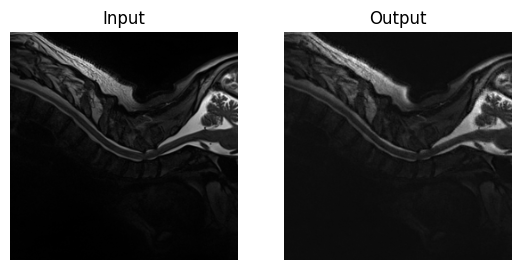

In [14]:
sample_idx = 0

input_ = torch.tensor(train_dataset[sample_idx]['data'][None]).to(device)
with torch.no_grad():
	z = vqgan.pre_vq_conv(vqgan.encoder(input_))
	# z is the image reprsentation in the latent space
	output = vqgan.decode(z)

#plot input and outputs middle slice
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(input_[0,0,input_.shape[2]//2,:,:].cpu().numpy(), cmap='gray')
plt.title('Input')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(output[0,0,output.shape[2]//2,:,:].cpu().numpy(), cmap='gray')
plt.title('Output')
plt.axis('off')



## Evaluate DDPM

## Load DDPM

In [6]:
model = Unet3D(
    dim=cfg.model.diffusion_img_size,
    dim_mults=cfg.model.dim_mults,
    channels=cfg.model.diffusion_num_channels,
).cuda(GPU_ID)

diffusion = GaussianDiffusion(
    model,
    vqgan_ckpt=cfg.model.vqgan_ckpt,
    image_size=cfg.model.diffusion_img_size,
    num_frames=cfg.model.diffusion_depth_size,
    channels=cfg.model.diffusion_num_channels,
    timesteps=cfg.model.timesteps,
    loss_type=cfg.model.loss_type,
).cuda(GPU_ID)


trainer = Trainer(
    diffusion,
    cfg=cfg,
    dataset=train_dataset,
    train_batch_size=cfg.model.batch_size,
    save_and_sample_every=cfg.model.save_and_sample_every,
    train_lr=cfg.model.train_lr,
    train_num_steps=cfg.model.train_num_steps,
    gradient_accumulate_every=cfg.model.gradient_accumulate_every,
    ema_decay=cfg.model.ema_decay,
    amp=cfg.model.amp,
    num_sample_rows=cfg.model.num_sample_rows,
    results_folder='samples',
    num_workers=cfg.model.num_workers,
)



loaded pretrained LPIPS loss from /home/ge.polymtl.ca/p120530/Training/Counterfactual_synthesis_for_lesion_segmentation/vq_gan_3d/model/cache/vgg.pth
found 14 videos as gif files at None


In [7]:
#trainer.load(DDPM_CHECKPOINT, map_location=f'cuda:{GPU_ID}')
trainer.load(DDPM_CHECKPOINT, map_location=device)

## Load T2I
Only if you want to use a T2I-adapter.
Make sure that the dataset includes the required derivative that the T2I expects. You can use the argument "mandatory_derivatives" in the second cell 

In [8]:
from T2I_Adapter.adapters import Adapter_Medical_Diffusion
T2I_checkpoint = 'T2I.pt'

# Load the T2I model
adapter = Adapter_Medical_Diffusion()
adapter.load_state_dict(torch.load(T2I_checkpoint))
adapter = adapter.to(device)

In [30]:
#Comparisons function between the original and the generated images and some post treatment usefull functions

def unsigned_difference(volume1, volume2, focus_mask = None):
    """ returns |volume1 - volume2| 
    if a segmentation is provided, the difference is only computed on the focus_mask region if provided
    """
    if focus_mask is None:
        focus_mask = np.ones(volume1.shape)
    diff = (volume1 - volume2) 
    diff = np.abs(diff) * focus_mask
    return diff

def smooth_filter(mask):
    """ Take a binary segmentation mask and apply a convolution to elivinate lonely pixels
    """
    kernel = np.array([[[0, 0.0, 0], [0, 0.1, 0], [0, 0.0, 0]],
                        [[0.0, 0.1, 0.0], [0.1, 0.2, 0.1], [0, 0.1, 0]],
                        [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]])
    kernel = torch.tensor(kernel)
    mask = torch.tensor(mask)
    mask = torch.nn.functional.conv3d(mask, kernel[None, None], padding=1)
    mask = binarise(mask)
    #mask to numpy
    mask = mask.cpu().numpy()
    return mask

def re_orient(image):
    """ Take a 2D of a spinal coord as input oriented as expected by the model 
    and return the image oriented as expected by the conventions
    """
    return np.flip(np.rot90(image,1),1)

def normalize(image, min_ = -1, max_ = 1):
    """ Normalize the image between min_ and max_ values
    """
    return (image - np.min(image)) * (max_ - min_) / (np.max(image) - np.min(image)) + min_

def binarise(image, threshold = 0.5, filter = None):
    """ Binarise the image with the given threshold
    One can provide a filter to post-treat the optained mask
    """
    image[image >= threshold] = 1
    image[image < threshold] = 0
    if filter is not None:
        image = filter(image)
    return image

def f1_score(y_pred, y_true):
    """ returns the f1 score between y_true and y_pred (volume wise)
    """
    TP = np.sum(y_true * y_pred)
    FP = np.sum((1-y_true) * y_pred)
    FN = np.sum(y_true * (1-y_pred))
    return 2 * TP / (2 * TP + + FP + FN)

In [31]:
# diffusion functions
def generate_img(T2I_features = None):
    """ Generate a diffusion image from the model
    """
    return trainer.ema_model.sample(batch_size=1, T2I_features=T2I_features).unbind(0)[0].cpu().numpy()


def img2img(sample, denoising = 0.2, comparison_mode = "Unsigned_difference", segmentation = None, T2I_features = None):
    """ Take a sample and a dataset and perform img2img diffusion,
    returns the input, the noised image before diffusion the output, and the comparison between input and ouput
    """

    input_ = torch.tensor(sample['data'][None]).to(device)
    noised_input = trainer.ema_model.noise_sample(input_image = input_, denoising = denoising, batch_size=1).unbind(0)[0].cpu().numpy()
    output = trainer.ema_model.sample(input_image = input_, denoising = denoising, batch_size=1, T2I_features=T2I_features).unbind(0)[0].cpu().numpy()
    input_ = input_.unbind(0)[0].cpu().numpy()

    return input_, noised_input, output

In [42]:
# ploting functions

def plot_img2img(input_, noised_input, output, output_file_name, denoising, mode = "gif", index = -1):
    """ Take the output of a img2img diffusion and plot the input, the noised input, the output and the comparison
    on the same figure. Save it to the given folder with appropriate name
    different modes are available : 
    - gif : all slices are displayed in a gif
    - static : only display the given slice (middle slice if index = -1)
    """

    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    if mode == "gif":  

        # Initialize images and texts
        im = axs[0].imshow(re_orient(input_[0][0]), cmap='gray', vmin=-1, vmax=1)
        im1 = axs[1].imshow(re_orient(noised_input[0][0]), cmap='gray', vmin=-1, vmax=1)
        im2 = axs[2].imshow(re_orient(output[0][0]), cmap='gray', vmin=-1, vmax=1)
        text = axs[0].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text1 = axs[1].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text2 = axs[2].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

        # Add a title
        axs[0].set_title('Input (GT before noising)')
        axs[1].set_title(f'Noised input (noise level : {denoising})')
        axs[2].set_title(f'Output')

        # Update function for the animation
        def gif_update(i):
            im.set_array(re_orient(input_[0][i]))
            im1.set_array(re_orient(noised_input)[0][i])
            im2.set_array(re_orient(output[0][i]))
            text.set_text(f'Slice : {i}')
            text1.set_text(f'Slice : {i}')
            text2.set_text(f'Slice : {i}')
            return [im, im1, im2, text, text1, text2]

        # Create the animation
        ani = animation.FuncAnimation(fig, gif_update, frames=len(output[0]), interval=200, blit=True)
        ani.save(f'{output_file_name}.gif')

    elif mode == "static":
        if index < 0:
            index = input_.shape[1]//2
        im = axs[0].imshow(re_orient(input_[0][index]), cmap='gray', vmin=0, vmax=1)
        im1 = axs[1].imshow(re_orient(noised_input)[0][index], cmap='gray', vmin=0, vmax=1)
        im2 = axs[2].imshow(re_orient(output[0][index]), cmap='gray', vmin=0, vmax=1)
        text = axs[0].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text1 = axs[1].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text2 = axs[2].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

        # Add a title
        axs[0].set_title('Input (GT before noising)')
        axs[1].set_title(f'Noised input (noise level : {denoising})')
        axs[2].set_title(f'Output')
        #desactivate axis
        for ax in axs:
            ax.axis('off')
            
        plt.savefig(f'{output_file_name}.png')
    else:
        print("Mode not recognized, please choose between gif and static")


def plot_img2img_segmentation(input_, output, GT, output_file_name, denoising, mode = "gif", index = -1, comparison_mode = "unsigned_difference", focus_mask = None, lesion_segmentation_threshold = 0, filter=None):
    """
    Take the output of a img2img diffusion and plot the input, the output, the comparison and the GT segmentation
    Save it to the given folder with appropriate name
    different modes are available : 
    - gif : all slices are displayed in a gif
    - static : only display the given slice (middle slice if index = -1)
    """
    if comparison_mode == "unsigned_difference":
        comparison = unsigned_difference(input_, output, focus_mask = focus_mask)[0]
    lesion_seg = binarise(comparison, lesion_segmentation_threshold, filter=filter)
    GT = binarise(GT) #makes sure the GT is binarised
    F1 = f1_score(lesion_seg, GT)
    colored_lesion_seg_shape = lesion_seg.shape
    colored_lesion_seg = np.zeros((3,colored_lesion_seg_shape[1],colored_lesion_seg_shape[2],colored_lesion_seg_shape[3]))
    # green channel : coorectly segmented region
    colored_lesion_seg[1] = lesion_seg * GT
    # red channel : over-segmented region
    colored_lesion_seg[0] = lesion_seg * (1 - GT)
    # blue channel : under-segmented region
    colored_lesion_seg[2] = (1 - lesion_seg) * GT
    # move the color channels to the end
    colored_lesion_seg = np.moveaxis(colored_lesion_seg, 0, -1)
    

    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    if mode == "gif":  

        # Initialize images and texts
        im = axs[0].imshow(re_orient(input_[0][0]), cmap='gray', vmin=-1, vmax=1)
        im1 = axs[1].imshow(re_orient(output[0][0]), cmap='gray', vmin=-1, vmax=1)
        im2 = axs[2].imshow(re_orient(colored_lesion_seg[0]), cmap='gray', vmin=0, vmax=1)
        im3 = axs[3].imshow(re_orient(GT[0][0]), cmap='gray', vmin=0, vmax=1)
        text = axs[0].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text1 = axs[1].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text2 = axs[2].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text3 = axs[3].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

        # Add a title
        axs[0].set_title('Input (GT before noising)')
        axs[1].set_title(f'Output (noise level : {round(denoising,2)})')
        axs[2].set_title(f'[input-output|>{lesion_segmentation_threshold}, F1 : {round(F1,2)}')
        axs[3].set_title(f'GT')

        #desactivate axis
        for ax in axs:
            ax.axis('off')

        # Update function for the animation
        def gif_update(i):
            im.set_array(re_orient(input_[0][i]))
            im1.set_array(re_orient(output[0][i]))
            im2.set_array(re_orient(colored_lesion_seg[i]))
            im3.set_array(re_orient(GT[0][i]))
            text.set_text(f'Slice : {i}')
            text1.set_text(f'Slice : {i}')
            text2.set_text(f'Slice : {i}')
            text3.set_text(f'Slice : {i}')
            return [im, im1, im2, im3, text, text1, text2, text3]

        # Create the animation
        ani = animation.FuncAnimation(fig, gif_update, frames=len(output[0]), interval=200, blit=True)
        ani.save(f'{output_file_name}.gif')

    elif mode == "static":
        if index < 0:
            index = input_.shape[1]//2
        im = axs[0].imshow(re_orient(input_[0][index]), cmap='gray', vmin=-1, vmax=1)
        im1 = axs[1].imshow(re_orient(output[0][index]), cmap='gray', vmin=-1, vmax=1)
        im2 = axs[2].imshow(re_orient(colored_lesion_seg[index]), cmap='gray', vmin=0, vmax=1)
        im3 = axs[3].imshow(re_orient(GT[0][index]), cmap='gray', vmin=0, vmax=1)
        text = axs[0].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text1 = axs[1].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text2 = axs[2].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        text3 = axs[3].text(15, 15, '', color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

        # Add a title
        axs[0].set_title('Input (GT before noising)')
        axs[1].set_title(f'Output (noise level : {denoising})')
        axs[2].set_title(f'[input-output|>{lesion_segmentation_threshold}, F1 : {round(F1,2)}')
        axs[3].set_title(f'GT')
        

        #desactivate axis
        for ax in axs:
            ax.axis('off')

        plt.savefig(f'{output_file_name}.png')
    else:
        print("Mode not recognized, please choose between gif and static")
    return F1


/tmp/ipykernel_1049666/464531608.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(sample['data'][None]).to(device)
sampling loop time step:  40%|████      | 120/300 [00:44<01:07,  2.68it/s]


0.7295733911785972


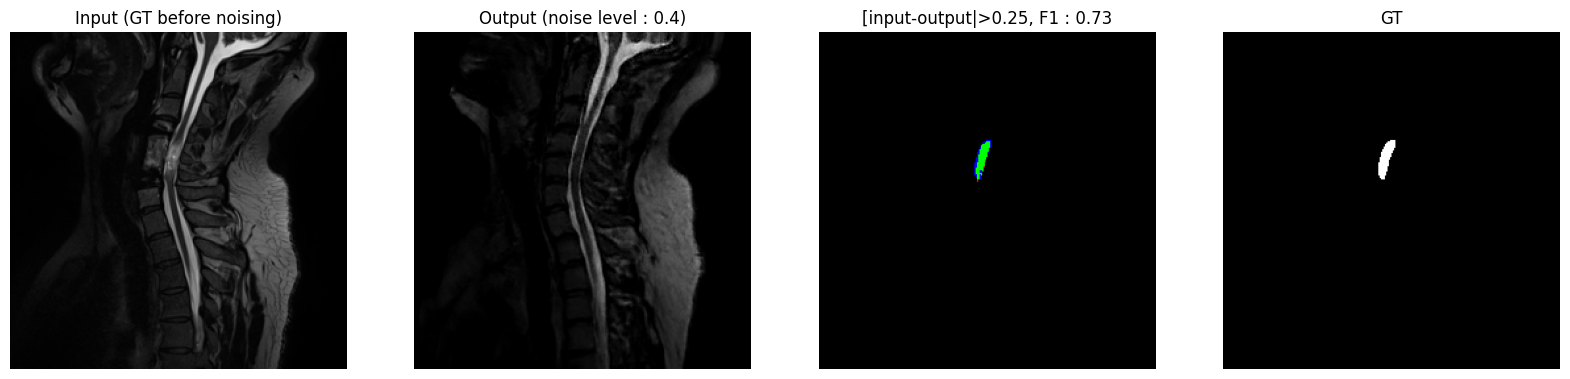

In [45]:
# Use the ddpm and the T2I model (optional) to perform img2img diffusion and lesion segmentation

sample_idx = 8 # the idx of the sample to treat in the dataset.
denoising = 0.4 # the level of noise to apply to the input before re-generating.
threshold = 0.25 # the threshold to apply to the difference between input and output to segment the lesion
use_T2I = True # whether to use the T2I model or not.
filter = smooth_filter # the filter to apply to the segmentation mask after thresholding
mode = "static" # the mode of the saved figure, either gif or static
output_folder = "samples" # the folder where to save the results

sample = train_dataset[sample_idx]

if use_T2I:
    T2I_features = adapter(sample['contrast-agnostic'][None].to(device))
else :
    T2I_features = None

input_, noised_input, output = img2img(sample, denoising = denoising, T2I_features = T2I_features)
F1 = (plot_img2img_segmentation(input_, output, sample['lesion-manual'], f'{output_folder}/img2img_segmentation_{dataset_name}-{sample_idx}_d-{denoising}_thr-{threshold}_T2I-{use_T2I}', denoising = denoising, mode = mode, comparison_mode="unsigned_difference", focus_mask=sample['contrast-agnostic'][None], lesion_segmentation_threshold = threshold, filter = filter))
print(F1)
